In [1]:
!pip install --upgrade transformers


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

In [2]:
WIDTH = 512
HEIGHT = 512

In [3]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        
#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

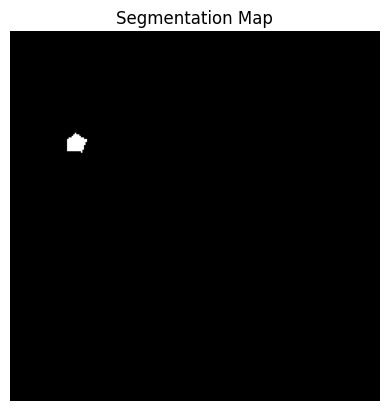

In [4]:
import cv2
import matplotlib.pyplot as plt

# Load the segmentation map using OpenCV
segmentation_map = cv2.imread("D:/RA/Models/SegFormer/USC_Data/annotations/validation/LUNA_MARIA_2017-09-28_LCC_1.2.840.113681.3482780046.1506585539.5264.5021.dcm.png")
segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)

# Display the segmentation map using matplotlib
plt.imshow(segmentation_map, cmap='gray')
plt.title('Segmentation Map')
plt.axis('off')  # Turn off axis labels
plt.show()


In [5]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [6]:
root_dir = 'D:/RA/Models/SegFormer/USC_Data'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

c:\Users\KETKI\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 100
Number of validation examples: 10


In [8]:
encoded_inputs = train_dataset[0]

In [9]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [10]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [11]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [12]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0, 255])

In [13]:
mask = encoded_inputs["labels"].numpy()

In [14]:
import matplotlib.pyplot as plt

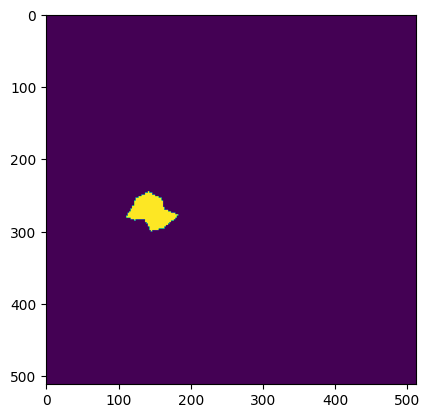

In [15]:
plt.imshow(mask)

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [19]:
batch["labels"].shape

torch.Size([4, 512, 512])

In [20]:
classes = pd.read_csv('D:/RA/Models/SegFormer/USC_Data/usc_class_dict_seg.csv')['name']
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [25]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


c:\Users\KETKI\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
for epoch in range(1, 100):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.8745123594300171         Train Loss: 0.508954428434372         Val Pixel-wise accuracy: 1.0         Val Loss: 0.3455053468545278
Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9860241098163676         Train Loss: 0.3308761215209961         Val Pixel-wise accuracy: 0.9999607575890993         Val Loss: 0.23371968666712442
Epoch: 3


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9985134017162715         Train Loss: 0.23849780082702637         Val Pixel-wise accuracy: 0.9999939381641698         Val Loss: 0.18836160004138947
Epoch: 4


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9990750149949289         Train Loss: 0.18395403385162354         Val Pixel-wise accuracy: 1.0         Val Loss: 0.14878107607364655
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9994904319158322         Train Loss: 0.15083838164806365         Val Pixel-wise accuracy: 1.0         Val Loss: 0.12008684128522873
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9996351493976299         Train Loss: 0.12409700095653534         Val Pixel-wise accuracy: 1.0         Val Loss: 0.10417355100313823
Epoch: 7


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9996738658707462         Train Loss: 0.10427195817232132         Val Pixel-wise accuracy: 1.0         Val Loss: 0.08915794889132182
Epoch: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998916573102664         Train Loss: 0.08964159399271011         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0757516399025917
Epoch: 9


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9997770757927233         Train Loss: 0.07835538238286972         Val Pixel-wise accuracy: 1.0         Val Loss: 0.06591312338908513
Epoch: 10


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998043496158665         Train Loss: 0.06756009072065354         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0559475893775622
Epoch: 11


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998449595407729         Train Loss: 0.059451780915260315         Val Pixel-wise accuracy: 1.0         Val Loss: 0.04977221538623174
Epoch: 12


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998653580891435         Train Loss: 0.053732696920633316         Val Pixel-wise accuracy: 1.0         Val Loss: 0.04407427956660589
Epoch: 13


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998685502528855         Train Loss: 0.04804119199514389         Val Pixel-wise accuracy: 1.0         Val Loss: 0.04179841155807177
Epoch: 14


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999279724668964         Train Loss: 0.043500187993049624         Val Pixel-wise accuracy: 1.0         Val Loss: 0.037576122830311455
Epoch: 15


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9998835152822559         Train Loss: 0.040030450224876404         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0324471207956473
Epoch: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999657801865393         Train Loss: 0.035693842619657516         Val Pixel-wise accuracy: 1.0         Val Loss: 0.029187966759006184
Epoch: 17


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999630231210846         Train Loss: 0.03362942866981029         Val Pixel-wise accuracy: 1.0         Val Loss: 0.030079422518610954
Epoch: 18


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999759727271958         Train Loss: 0.030715045407414435         Val Pixel-wise accuracy: 1.0         Val Loss: 0.02482364575068156
Epoch: 19


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999272964265147         Train Loss: 0.028315467089414598         Val Pixel-wise accuracy: 1.0         Val Loss: 0.02395363214115302
Epoch: 20


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999650830766486         Train Loss: 0.025849608182907106         Val Pixel-wise accuracy: 1.0         Val Loss: 0.021268635988235474
Epoch: 21


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999519036588412         Train Loss: 0.023199278190732003         Val Pixel-wise accuracy: 1.0         Val Loss: 0.020325838898619015
Epoch: 22


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999260159217731         Train Loss: 0.021777268648147583         Val Pixel-wise accuracy: 1.0         Val Loss: 0.01841062121093273
Epoch: 23


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999905463034522         Train Loss: 0.02023153729736805         Val Pixel-wise accuracy: 1.0         Val Loss: 0.01734983983139197
Epoch: 24


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.999960176863964         Train Loss: 0.01896879494190216         Val Pixel-wise accuracy: 1.0         Val Loss: 0.01627829298377037
Epoch: 25


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.999977303471043         Train Loss: 0.0178667177259922         Val Pixel-wise accuracy: 1.0         Val Loss: 0.01575434332092603
Epoch: 26


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999749201117609         Train Loss: 0.01683434072881937         Val Pixel-wise accuracy: 1.0         Val Loss: 0.014413153131802877
Epoch: 27


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999877040703045         Train Loss: 0.015884542278945445         Val Pixel-wise accuracy: 1.0         Val Loss: 0.013141047519942125
Epoch: 28


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999663918023352         Train Loss: 0.01506350450217724         Val Pixel-wise accuracy: 1.0         Val Loss: 0.012343698802093664
Epoch: 29


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999903691401562         Train Loss: 0.014228009507060052         Val Pixel-wise accuracy: 1.0         Val Loss: 0.012114063215752443
Epoch: 30


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999607502508162         Train Loss: 0.013071182072162629         Val Pixel-wise accuracy: 1.0         Val Loss: 0.011217891549070677
Epoch: 31


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999988050405652         Train Loss: 0.012767696343362332         Val Pixel-wise accuracy: 1.0         Val Loss: 0.010796645656228065
Epoch: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999755437343422         Train Loss: 0.011695479936897756         Val Pixel-wise accuracy: 1.0         Val Loss: 0.009960908442735672
Epoch: 33


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999821766412722         Train Loss: 0.011480984836816787         Val Pixel-wise accuracy: 1.0         Val Loss: 0.00951437217493852
Epoch: 34


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999937634538151         Train Loss: 0.010979636795818806         Val Pixel-wise accuracy: 1.0         Val Loss: 0.00905298131207625
Epoch: 35


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999945085876782         Train Loss: 0.010797729529440404         Val Pixel-wise accuracy: 1.0         Val Loss: 0.008715233455101648
Epoch: 36


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999897434251556         Train Loss: 0.009829635322093964         Val Pixel-wise accuracy: 1.0         Val Loss: 0.008369115802148977
Epoch: 37


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999934627903281         Train Loss: 0.009325013905763626         Val Pixel-wise accuracy: 1.0         Val Loss: 0.007830568744490543
Epoch: 38


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999968624483089         Train Loss: 0.009562039710581303         Val Pixel-wise accuracy: 1.0         Val Loss: 0.007758462801575661
Epoch: 39


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999977446126966         Train Loss: 0.009069491252303124         Val Pixel-wise accuracy: 1.0         Val Loss: 0.007207712158560753
Epoch: 40


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999904040374992         Train Loss: 0.00853442620486021         Val Pixel-wise accuracy: 1.0         Val Loss: 0.006776351016014814
Epoch: 41


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999922026681977         Train Loss: 0.008142293393611909         Val Pixel-wise accuracy: 1.0         Val Loss: 0.006753408660491307
Epoch: 42


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999823812838984         Train Loss: 0.007605382017791271         Val Pixel-wise accuracy: 1.0         Val Loss: 0.006371470478673776
Epoch: 43


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999984930773402         Train Loss: 0.007454050108790398         Val Pixel-wise accuracy: 1.0         Val Loss: 0.006096646500130494
Epoch: 44


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999908183780899         Train Loss: 0.007021516636013985         Val Pixel-wise accuracy: 1.0         Val Loss: 0.005889221249769132
Epoch: 45


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999876587392046         Train Loss: 0.006695334985852242         Val Pixel-wise accuracy: 1.0         Val Loss: 0.005731168203055859
Epoch: 46


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.006455927472561598         Val Pixel-wise accuracy: 1.0         Val Loss: 0.005460688844323158
Epoch: 47


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999968843516875         Train Loss: 0.006111161410808563         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0051199413525561495
Epoch: 48


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999969276970924         Train Loss: 0.006013825945556164         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0049051389408608275
Epoch: 49


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999914834115802         Train Loss: 0.005791077744215727         Val Pixel-wise accuracy: 1.0         Val Loss: 0.004784822619209687
Epoch: 50


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999955444823533         Train Loss: 0.005549941752105951         Val Pixel-wise accuracy: 1.0         Val Loss: 0.004622222700466712
Epoch: 51


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999910503317264         Train Loss: 0.005420966390520334         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0043449851994713145
Epoch: 52


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.005285897310823202         Val Pixel-wise accuracy: 1.0         Val Loss: 0.00444991576174895
Epoch: 53


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999924010392973         Train Loss: 0.005020706206560135         Val Pixel-wise accuracy: 1.0         Val Loss: 0.004107684517900149
Epoch: 54


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999781553473386         Train Loss: 0.0047613141965121035         Val Pixel-wise accuracy: 1.0         Val Loss: 0.003913103990877668
Epoch: 55


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999923487553306         Train Loss: 0.00457005625590682         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0038584263529628515
Epoch: 56


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999998035733928         Train Loss: 0.0045375914871692655         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0036716573716451726
Epoch: 57


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999971277940989         Train Loss: 0.004473279723897577         Val Pixel-wise accuracy: 1.0         Val Loss: 0.003650649761160215
Epoch: 58


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999998445989391         Train Loss: 0.004274786673486233         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0035658200892309346
Epoch: 59


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999790586901807         Train Loss: 0.004118564706295728         Val Pixel-wise accuracy: 1.0         Val Loss: 0.003437774178261558
Epoch: 60


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999972163483859         Train Loss: 0.004039219813421369         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0032792904724677405
Epoch: 61


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999972534744677         Train Loss: 0.0038221416808664798         Val Pixel-wise accuracy: 1.0         Val Loss: 0.003158581986402472
Epoch: 62


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0037231100909411907         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0029832837947954736
Epoch: 63


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0036024387646466493         Val Pixel-wise accuracy: 1.0         Val Loss: 0.003010012519856294
Epoch: 64


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999979778178245         Train Loss: 0.0034698214288800956         Val Pixel-wise accuracy: 1.0         Val Loss: 0.002831311042731007
Epoch: 65


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999930987732306         Train Loss: 0.0034138376358896494         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0027455201682945094
Epoch: 66


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.003229662775993347         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0027160370567192635
Epoch: 67


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999996883096643         Train Loss: 0.0031014876905828713         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0026024021984388432
Epoch: 68


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999964749887282         Train Loss: 0.003127534156665206         Val Pixel-wise accuracy: 1.0         Val Loss: 0.002518988369653622
Epoch: 69


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999936171761388         Train Loss: 0.0030757937766611575         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0024692730512470007
Epoch: 70


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.999999000997005         Train Loss: 0.002981459712609649         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0024227818939834833
Epoch: 71


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0028050134517252443         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0022702423545221486
Epoch: 72


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999947576714747         Train Loss: 0.00279471380636096         Val Pixel-wise accuracy: 1.0         Val Loss: 0.002293334652980169
Epoch: 73


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0027155964821577072         Val Pixel-wise accuracy: 1.0         Val Loss: 0.002280902893592914
Epoch: 74


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999999211778396         Train Loss: 0.002688321899622679         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0021484934259206057
Epoch: 75


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999985095084298         Train Loss: 0.002606717925518751         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0021229058038443327
Epoch: 76


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0025620961654931307         Val Pixel-wise accuracy: 1.0         Val Loss: 0.002071463270112872
Epoch: 77


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0024797856248915196         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0019737561233341694
Epoch: 78


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0024271360132843258         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0019633403280749917
Epoch: 79


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999993533400492         Train Loss: 0.0023287641163915397         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0018631791463121772
Epoch: 80


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999994154844026         Train Loss: 0.0022252897825092077         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0018164986201251547
Epoch: 81


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0021473459992557764         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0017841912728423874
Epoch: 82


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999999217257897         Train Loss: 0.002148666041903198         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001713661787410577
Epoch: 83


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0020535630639642475         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0016593826779474814
Epoch: 84


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999993334685999         Train Loss: 0.0019814562425017356         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0016514008166268468
Epoch: 85


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999992931231684         Train Loss: 0.0019104649079963564         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001596754106382529
Epoch: 86


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999999204155106         Train Loss: 0.0019141603680327534         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001537854705626766
Epoch: 87


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0018168477201834321         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0014958819762493174
Epoch: 88


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.001853348626755178         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0015075398453821738
Epoch: 89


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0017444605473428965         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0015001853850359719
Epoch: 90


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0017667902586981654         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0014003336351985733
Epoch: 91


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0017357997177168726         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001338083258209129
Epoch: 92


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0016774178855121136         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001397226471453905
Epoch: 93


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999957433817103         Train Loss: 0.001609419658780098         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001318824749129514
Epoch: 94


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.00159763403236866         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0013100823853164911
Epoch: 95


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.00158490392845124         Val Pixel-wise accuracy: 1.0         Val Loss: 0.00128814783723404
Epoch: 96


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0014655715133994817         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0012256383973484237
Epoch: 97


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 1.0         Train Loss: 0.0014653409831225871         Val Pixel-wise accuracy: 1.0         Val Loss: 0.0012647598050534725
Epoch: 98


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999998836687389         Train Loss: 0.0014681018004193901         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001145793862330417
Epoch: 99


  0%|          | 0/25 [00:00<?, ?it/s]

Train Pixel-wise accuracy: 0.9999998842133602         Train Loss: 0.0013988750940188766         Val Pixel-wise accuracy: 1.0         Val Loss: 0.001153642622133096


# Hugging Face Inference 🤗

In [28]:
from sklearn.metrics import accuracy_score
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn

In [29]:
df = pd.read_csv('D:/RA/Models/SegFormer/USC_Data/usc_class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [30]:
root_dir = 'D:/RA/Models/SegFormer/USC_Data'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

c:\Users\KETKI\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at deep-learning-analytics/segformer_semantic_segmentation and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([24, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([24]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
import os
import torch

# Define the directory where you want to save the model
save_dir = 'D:/RA/Models/SegFormer/USC_Data'

# Make sure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Define a filename for the saved model
model_filename = 'segformer_model.pth'

# Save the model weights and configuration
torch.save(model.state_dict(), os.path.join(save_dir, model_filename))

import pickle
import os

# Save custom feature extractor data to a file
feature_extractor_data = {
    'align': feature_extractor.align,
    'reduce_zero_label': feature_extractor.reduce_zero_label
}

feature_extractor_filename = 'feature_extractor.pkl'
with open(os.path.join(save_dir, feature_extractor_filename), 'wb') as file:
    pickle.dump(feature_extractor_data, file)

# Load custom feature extractor data from the saved file
with open(os.path.join(save_dir, feature_extractor_filename), 'rb') as file:
    loaded_feature_extractor_data = pickle.load(file)

loaded_feature_extractor = SegformerFeatureExtractor(
    align=loaded_feature_extractor_data['align'],
    reduce_zero_label=loaded_feature_extractor_data['reduce_zero_label']
)


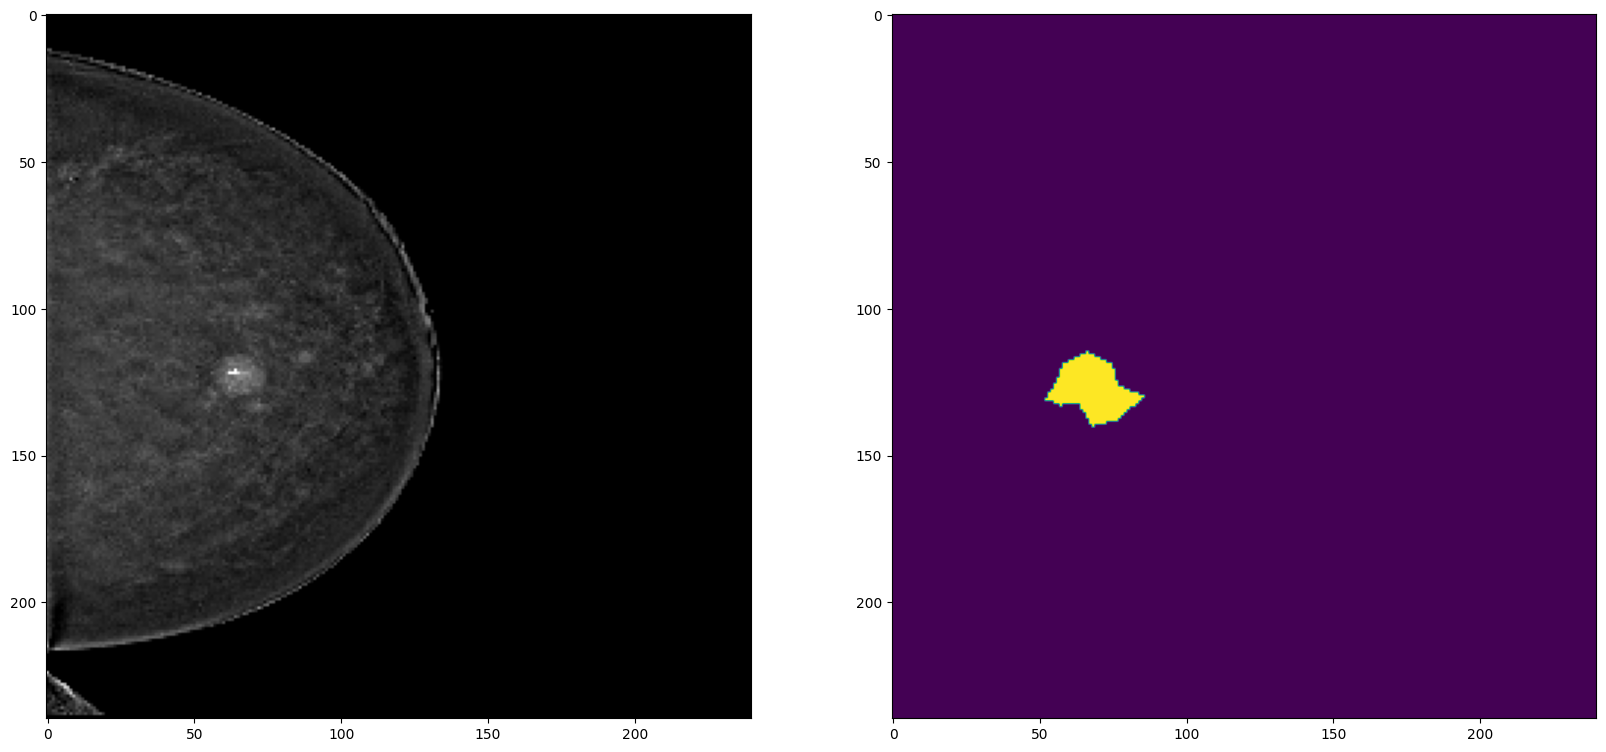

In [35]:
image = Image.open('D:/RA/Models/SegFormer/USC_Data/images/training/ALVAREZ_WENDY_2020-03-03_LCC_1.2.840.113681.175930252.1583221178.4436.47133.dcm.png')
mask = Image.open('D:/RA/Models/SegFormer/USC_Data/annotations/training/ALVAREZ_WENDY_2020-03-03_LCC_1.2.840.113681.175930252.1583221178.4436.47133.dcm.png').convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [41]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [42]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])
